In [19]:
import pandas as pd 


desktop_malware = pd.read_csv('../Datasets/JA4/Dataset2/desktop-malware.csv', sep=';')
desktop_apps_1 = pd.read_csv('../Datasets/JA4/Dataset2/desktop-apps.csv', sep=';')
desktop_apps_2 = pd.read_csv('../Datasets/JA4/Dataset1/Benign.csv', sep=';')
desktop_apps_3 = pd.read_csv('../Datasets/JA4/Dataset2/mydesktop-apps.csv', sep=';')
print(len(desktop_apps_3))


2566


In [20]:
drop_families = ["Sodinokibi", "Hawkeye", "Nanocore", "IceID", "Wannacry"]
desktop_malware = desktop_malware[~desktop_malware['AppName'].isin(drop_families)]

In [22]:
desktop_malware['label'] = 'DM'
desktop_apps_1['label'] = 'DA'
desktop_apps_2['label'] = 'DA'  # Asignamos DA si son aplicaciones benignas de escritorio
desktop_apps_3['label'] = 'DA'

df_combined = pd.concat([
    desktop_malware,
    desktop_apps_1,
    desktop_apps_2,
    desktop_apps_3,
], ignore_index=True)

# Verificar las primeras filas
print(df_combined.head())

                                 SNI  \
0  binaries.templates.cdn.office.net   
1  binaries.templates.cdn.office.net   
2  binaries.templates.cdn.office.net   
3  binaries.templates.cdn.office.net   
4  binaries.templates.cdn.office.net   

                                             OrgName  \
0  Network Architecture Role Account, AKAMAI-PA (GB)   
1  Network Architecture Role Account, AKAMAI-PA (GB)   
2  Network Architecture Role Account, AKAMAI-PA (GB)   
3  Network Architecture Role Account, AKAMAI-PA (GB)   
4  Network Architecture Role Account, AKAMAI-PA (GB)   

                            JA3hash                               JA4hash  \
0  a0e9f5d64349fb13191bc781f81f42e1  t12d190800_d83cc789557e_7af1ed941c26   
1  a0e9f5d64349fb13191bc781f81f42e1  t12d190800_d83cc789557e_7af1ed941c26   
2  a0e9f5d64349fb13191bc781f81f42e1  t12d190800_d83cc789557e_7af1ed941c26   
3  a0e9f5d64349fb13191bc781f81f42e1  t12d190800_d83cc789557e_7af1ed941c26   
4  a0e9f5d64349fb13191bc781f81f42e1  

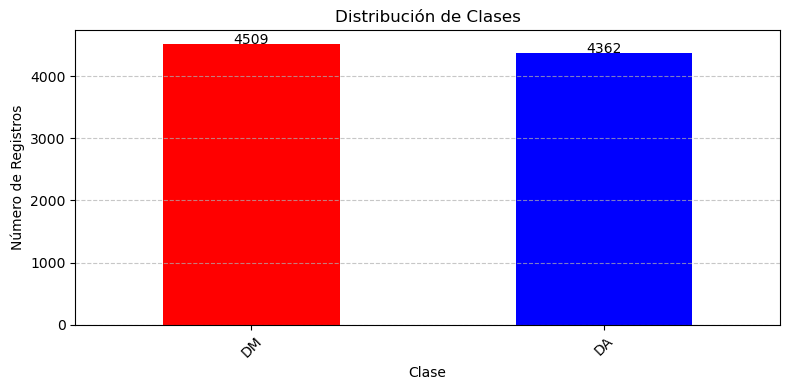

In [23]:
import matplotlib.pyplot as plt

# Contar registros por label
counts = df_combined['label'].value_counts()

# Gráfico de barras
plt.figure(figsize=(8, 4))
counts.plot(kind='bar', color=['red', 'blue', 'green', 'purple'])
plt.title('Distribución de Clases')
plt.xlabel('Clase')
plt.ylabel('Número de Registros')

# Usar las categorías únicas de counts.index para los ticks
plt.xticks(ticks=range(len(counts)), labels=counts.index, rotation=45)  # <- Corrección aquí
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar valores en las barras
for i, count in enumerate(counts):
    plt.text(i, count + 5, str(count), ha='center')

plt.tight_layout()
plt.show()

In [24]:
df_hashing = df_combined.drop(columns=['SrcIP', 'DstIP', 'SrcPort', 'DstPort', 'OrgName', 'JA3hash', 'JA3Shash', 'Version', 'Issuer', 'Subject'])

print(df_hashing.columns)

Index(['SNI', 'JA4hash', 'AppName', 'Type', 'JA4Shash', 'Filename', 'JA4X',
       'ja4ts', 'label'],
      dtype='object')


In [25]:
df_combined["JA4+JA4S"] = df_combined["JA4hash"].astype(str) + "_" + df_combined["JA4Shash"].astype(str)

unique_fingerprints = df_combined["JA4+JA4S"].value_counts().to_dict()
print(f"JA4 JA4S unique fingerprints: {len(unique_fingerprints)}")

JA4 JA4S unique fingerprints: 455


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_combined['label'])

hasher = FeatureHasher(n_features=1024, input_type='string')
X = hasher.fit_transform(df_combined[['JA4hash', 'JA4Shash']].astype(str).values.tolist())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

featureHasher = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # Para manejar desbalanceo
    random_state=42
)
featureHasher.fit(X_train, y_train)



y_pred_featureHasher = featureHasher.predict(X_test)
print(classification_report(y_test, y_pred_featureHasher))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1309
           1       0.95      0.94      0.94      1353

    accuracy                           0.94      2662
   macro avg       0.94      0.94      0.94      2662
weighted avg       0.94      0.94      0.94      2662



In [27]:
print(f"The score of the algorithm: {featureHasher.score(X_test,y_test)*100}")

The score of the algorithm: 94.32757325319308


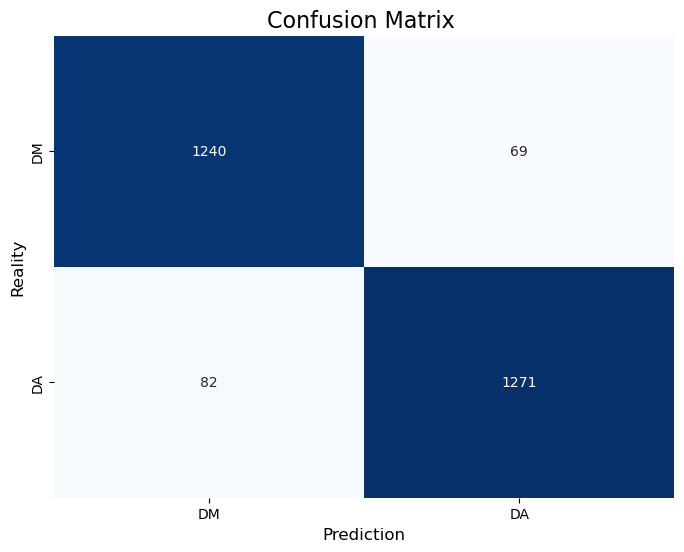

In [28]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_featureHasher)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=df_combined['label'].unique(), yticklabels=df_combined['label'].unique(), cbar=False)
plt.title('Confusion Matrix ', fontsize=16)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Reality', fontsize=12)


plt.show()

In [29]:
accuracy = accuracy_score(y_test, y_pred_featureHasher)
precision = precision_score(y_test, y_pred_featureHasher, average='macro')  # Puedes usar 'micro', 'macro', 'weighted' 
recall = recall_score(y_test, y_pred_featureHasher, average='macro')
f1 = f1_score(y_test, y_pred_featureHasher, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9433
Precision: 0.9432
Recall: 0.9433
F1 Score: 0.9433


In [30]:
df_combined["JA4+JA4S+JA4TS"] = df_combined["JA4hash"].astype(str) + "_" + df_combined["JA4Shash"].astype(str) + "_" + df_combined["ja4ts"]

unique_fingerprints = df_combined["JA4+JA4S+JA4TS"].value_counts().to_dict()
print(f"JA4 JA4S unique fingerprints: {len(unique_fingerprints)}")

JA4 JA4S unique fingerprints: 705


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_combined['label'])

hasher = FeatureHasher(n_features=1024, input_type='string')
X = hasher.fit_transform(df_combined[['JA4hash', 'JA4Shash', "ja4ts"]].astype(str).values.tolist())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

featureHasher = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # Para manejar desbalanceo
    random_state=42
)
featureHasher.fit(X_train, y_train)



y_pred_featureHasher = featureHasher.predict(X_test)
print(classification_report(y_test, y_pred_featureHasher))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1309
           1       0.96      0.96      0.96      1353

    accuracy                           0.96      2662
   macro avg       0.96      0.96      0.96      2662
weighted avg       0.96      0.96      0.96      2662



In [32]:
print(f"The score of the algorithm: {featureHasher.score(X_test,y_test)*100}")

The score of the algorithm: 96.28099173553719


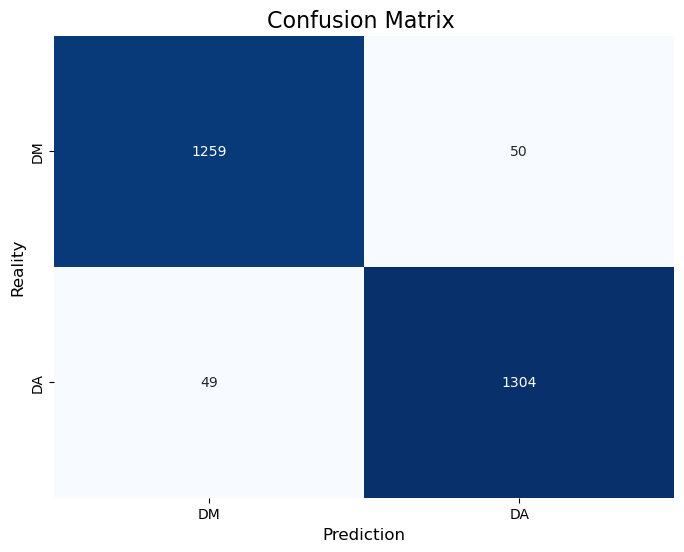

In [33]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_featureHasher)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=df_combined['label'].unique(), yticklabels=df_combined['label'].unique(), cbar=False)
plt.title('Confusion Matrix ', fontsize=16)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Reality', fontsize=12)


plt.show()

In [34]:
accuracy = accuracy_score(y_test, y_pred_featureHasher)
precision = precision_score(y_test, y_pred_featureHasher, average='macro')  # Puedes usar 'micro', 'macro', 'weighted' 
recall = recall_score(y_test, y_pred_featureHasher, average='macro')
f1 = f1_score(y_test, y_pred_featureHasher, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9628
Precision: 0.9628
Recall: 0.9628
F1 Score: 0.9628
